Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\ijung\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


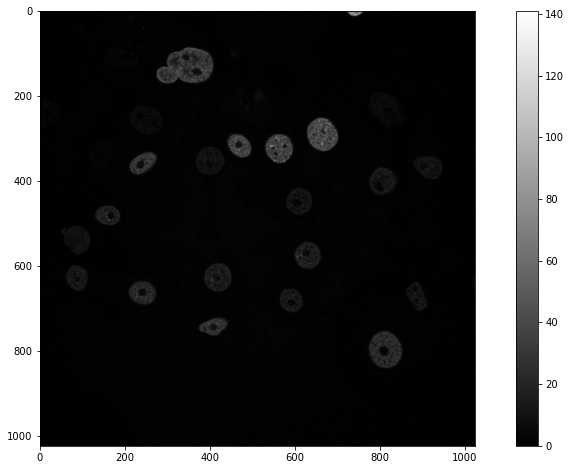

In [1]:
%pylab
%matplotlib inline
import skimage.io as sk

img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Versuch Bild zu laden

def show_image(img, x, y): # Funktion um Bilder anzuzeigen
    figure(figsize=(x,y)) #define image size
    imshow(img, "gray") #show black and white image
    colorbar() #show a color scale next to image

show_image(img, 15, 8)

In [2]:
def standarddeviation(img, size): # calculates standard deviation of every pixel (image, size of filter mask)
    result = numpy.zeros(img.shape) # create empty array (zeros)
    n = (size - 1) // 2
    for p in ndindex(img.shape): # iterates over every pixel
        neighborhood_sum = 0
        mean = 0
        deviation = 0
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # no calculation of border pixels
            for q in ndindex(size, size): # iterates over filter mask (nxn neighborhood)
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_sum += img[i,j]
            mean = neighborhood_sum/(size**2) # calculate mean in nxn neighborhood
            for q in ndindex(size, size): # iterates over filter mask (nxn neighborhood)
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                deviation += (img[i,j] - mean)**2 # calculate deviation from mean

            result[p] = sqrt(1/(size**2) * deviation) # calculate standard deviation
    return result
sd_test = standarddeviation(img,3)

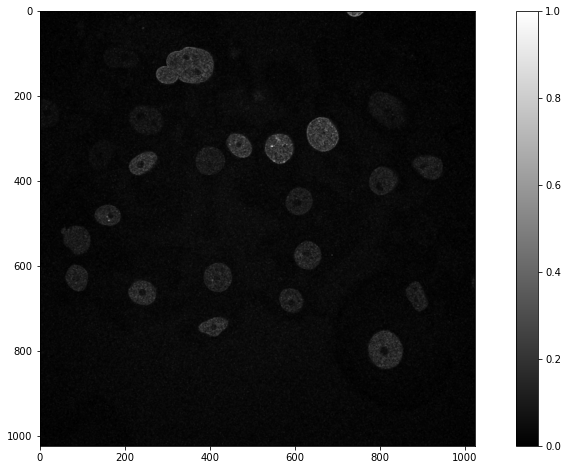

In [3]:
fl = sd_test.flatten()
max(fl) # maximale Standardabweichung

sd_n = sd_test.copy()/max(fl) # Bild auf sd genormt

show_image(sd_n, 15, 8)



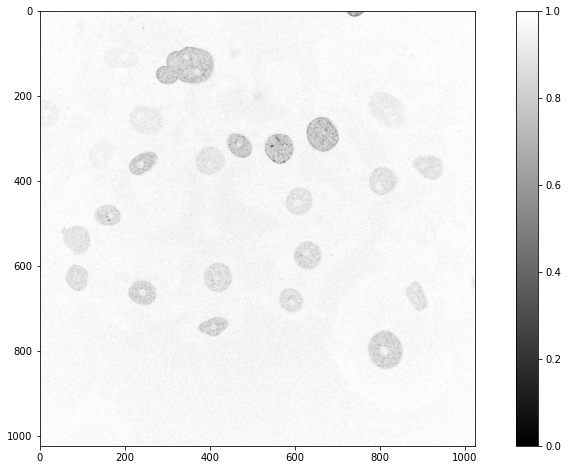

In [4]:
similarity = 1-sd_n # Similarity berechnen
# Grenzwert noch nicht bestimmt!
show_image(similarity, 15, 8)

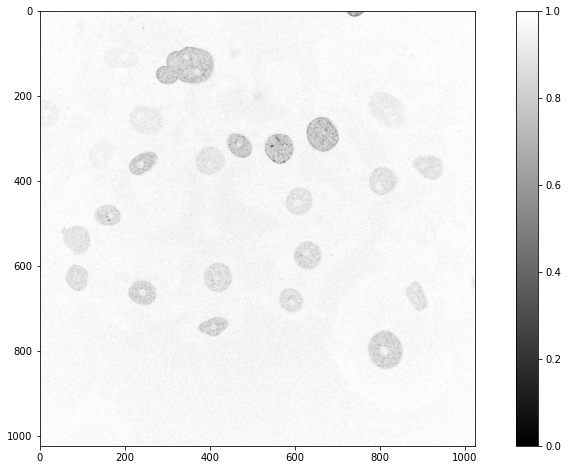

In [5]:
sd_2 = standarddeviation(img,3) # apply method for testing
sd_2 = sd_2/max(sd_2.flatten()) # normes standard deviation
similarity_2 = 1-sd_2 # calculates similarity
show_image(similarity_2, 15, 8)

<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


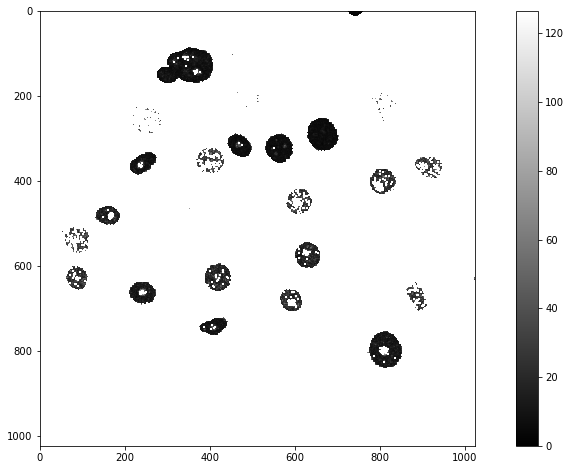

In [6]:
def euclidean_relative(img, size): # calculates maximum relative euclidean distance for every pixel in nxn neighborhood
    result = numpy.zeros(img.shape) # create empty array (zeros)
    n = (size - 1) // 2
    for p in ndindex(img.shape): # iterates over every pixel using a touple
        neighborhood_distance = [] # creates a list for distances
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # no calculation of border pixels
            for q in ndindex(size, size): # iterates over nxn neighborhood
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list

            result[p] = max(neighborhood_distance) # chooses maximum distance
    return result

eurel_test = euclidean_relative(img, 3)
show_image(eurel_test, 15, 8)

<ipython-input-7-fb54b1ce7c6e>:10: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])) # adds euclidean distance to list


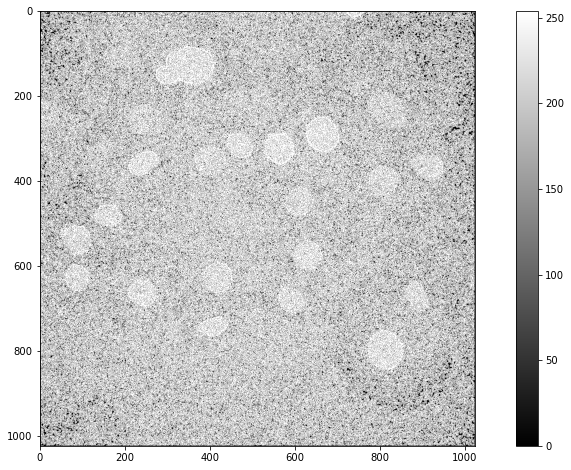

In [7]:
def euclidean_n(img, size): # calculates maximum euclidean distance for every pixel in nxn neighborhood
    result = numpy.zeros(img.shape) # create empty array (zeros)
    n = (size - 1) // 2
    for p in ndindex(img.shape): # iterates over every pixel using a touple
        neighborhood_distance = [] # creates a list for distances
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # no calculation of border pixels
            for q in ndindex(size, size): # iterates over nxn neighborhood
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_distance.append((img[p]-img[i,j])) # adds euclidean distance to list
            result[p] = max(neighborhood_distance) # chooses maximum distance
    return result

eu_test = euclidean_n(img, 3)
show_image(eu_test, 15, 8)

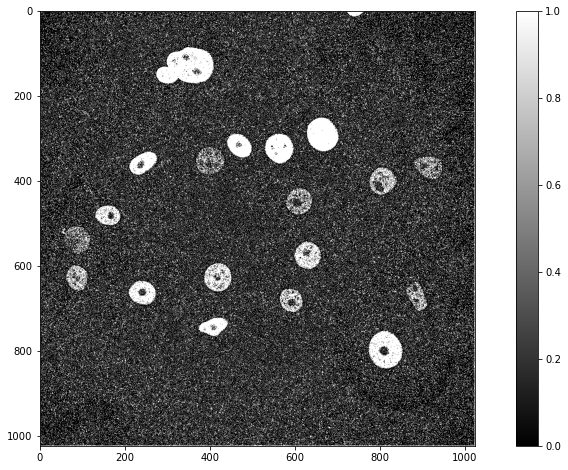

In [8]:
T1 = 0.4 # Wert anhand Bild geschätzt
T2 = 30 # Wert anhand Bild geschätzt

def seeds_test(img):
    result = numpy.zeros(img.shape)
    for p in ndindex(img.shape): # Ränder haben den Wert 0
        if similarity[p] > T1 and eurel_test[p] < T2: # Theorie aus Paper 1
            result[p] = 1 # Pixel die als Seed in Frage kommen sind weiß, der Rest ist schwarz
    return result

seed_t = seeds_test(img)
show_image(seed_t, 15, 8)

<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
<ipython-input-6-ad53d116d54a>:10: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


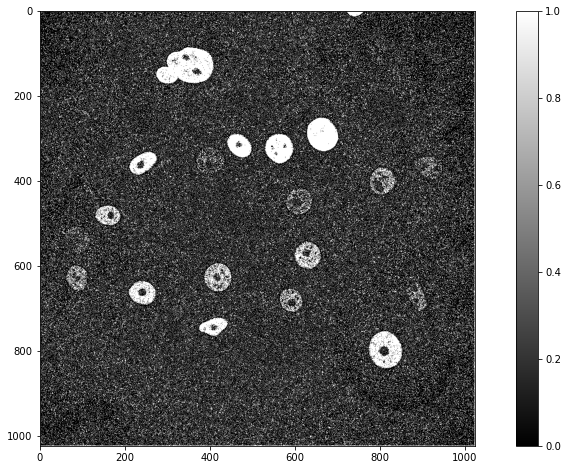

In [9]:
def seeds(img, T1, T2): # automatic seed selection algorithm
    result = numpy.zeros(img.shape)
    sd_seeds = standarddeviation(img,3) # standard deviation
    sd_flat = sd_seeds.flatten() # standard deviation as 1D-array
    similarity_seeds = 1 - sd_seeds/max(sd_flat) # calculates similarity of every pixel to its neighbors
    eurel_seeds = euclidean_relative(img, 3) # relative euclidean distance of every pixel to its neighbors
    for p in ndindex(img.shape): # border pixel value is zero
        if similarity_seeds[p] > T1 and eurel_seeds[p] < T2: # compares pixel with threshold
            result[p] = 1 # assigns value 1 to seeds
    return result

seed_final = seeds(img, 0.4, 20)
show_image(seed_final, 15, 8)